# Exploring DeepGaze on NSD stimuli (COCO images) 

In [1]:
import numpy as np
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp
import torch

import matplotlib.pyplot as plt


/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import h5py
import os
import sys
import struct
import time
import pandas as pd
from scipy.io import loadmat


To install DeepGaze on project directory:

Inside the `src/DeepGaze/` directory use `pip install -e .`. 

In [3]:
import src.DeepGaze.deepgaze_pytorch as deepgaze_pytorch

## Run DeepGaze example 

In [5]:
# DEVICE = 'cuda'
DEVICE = 'cpu'
# you can use DeepGazeI or DeepGazeIIE
model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)

image = face()

# load precomputed centerbias log density (from MIT1003) over a 1024x1024 image
# you can download the centerbias from https://github.com/matthias-k/DeepGaze/releases/download/v1.0.0/centerbias_mit1003.npy
# alternatively, you can use a uniform centerbias via `centerbias_template = np.zeros((1024, 1024))`.
centerbias_template = np.load('../src/DeepGaze/centerbias_mit1003.npy')
# rescale to match image size
centerbias = zoom(centerbias_template, (image.shape[0]/centerbias_template.shape[0], image.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
# renormalize log density
centerbias -= logsumexp(centerbias)

image_tensor = torch.tensor([image.transpose(2, 0, 1)]).to(DEVICE)
centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)

log_density_prediction = model(image_tensor, centerbias_tensor)

Loaded pretrained weights for efficientnet-b5


Using cache found in /gpfs01/bartels/user/hbhatnagar/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /gpfs01/bartels/user/hbhatnagar/.cache/torch/hub/pytorch_vision_v0.6.0
/tmp/ipykernel_54377/1822344403.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484683044/work/torch/csrc/utils/tensor_new.cpp:201.)
  image_tensor = torch.tensor([image.transpose(2, 0, 1)]).to(DEVICE)


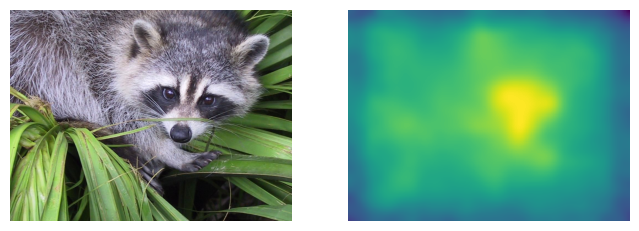

In [6]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axs[0].imshow(image)
axs[0].set_axis_off()

axs[1].matshow(log_density_prediction.detach().cpu().numpy()[0, 0])  # first image in batch, first (and only) channel
axs[1].set_axis_off()

In [7]:
log_density_prediction

tensor([[[[-19.4215, -19.4215, -19.4340,  ..., -23.7496, -23.7911, -23.7911],
          [-19.4215, -19.4215, -19.4340,  ..., -23.7496, -23.7911, -23.7911],
          [-19.4240, -19.4240, -19.4364,  ..., -23.7281, -23.7688, -23.7688],
          ...,
          [-21.1066, -21.1066, -21.1042,  ..., -20.6563, -20.6727, -20.6727],
          [-21.1329, -21.1329, -21.1303,  ..., -20.6492, -20.6657, -20.6657],
          [-21.1329, -21.1329, -21.1303,  ..., -20.6492, -20.6657, -20.6657]]]],
       dtype=torch.float64, grad_fn=<LogsumexpBackward0>)

In [8]:
print(image_tensor.shape)
print(image.shape)
print(log_density_prediction.shape)

torch.Size([1, 3, 768, 1024])
(768, 1024, 3)
torch.Size([1, 1, 768, 1024])


## Run DeepGaze on COCO examples

In [9]:
COCO_ROOT = '/gpfs01/bartels/user/hbhatnagar/coco/panoptic_annotations_trainval2017'
NSD_ROOT  = "/gpfs01/bartels/user/hbhatnagar/NSD_dataset/"
STIM_ROOT  = NSD_ROOT + "nsddata_stimuli/stimuli/nsd/"


stim_file = STIM_ROOT + "nsd_stimuli.hdf5"
exp_design_file = NSD_ROOT + "nsddata/experiments/nsd/nsd_expdesign.mat"
nsd_stiminfo_file = '/gpfs01/bartels/user/hbhatnagar/NSD_dataset/nsddata/experiments/nsd/nsd_stim_info_merged.pkl'


In [10]:
image_data_set = h5py.File(stim_file, 'r')

for key, value in image_data_set.items() :
    print(key,": \n", value,"\n")
    
image_data = np.copy(image_data_set['imgBrick'])
image_data_set.close()

imgBrick : 
 <HDF5 dataset "imgBrick": shape (73000, 425, 425, 3), type "|u1"> 



In [11]:
stiminfo = pd.read_pickle(nsd_stiminfo_file)

subject=1

image_data_set = h5py.File(STIM_ROOT + "S%d_stimuli_227.h5py"%subject, 'r') # For example - S01_stimuli_227.h5py
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()

print (image_data.shape) # Orig. 10,000 x 3 x 227 x 227
print (image_data.dtype)
print (np.min(image_data[0]), np.max(image_data[0]))

(10000, 3, 227, 227)
uint8
0 255


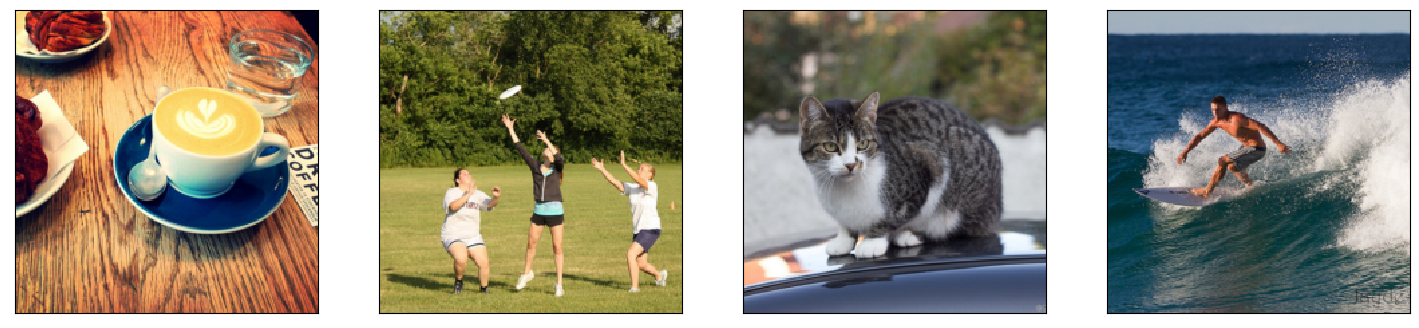

In [12]:
plt.figure(figsize=(18,6))

num_images = 4 
for i in range(num_images):
    plt.subplot(1,num_images,i+1)
    plt.imshow(image_data[6+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

In [13]:
# RUN ONLY IF MODEL HAS NOT BEEN INSTANTIATED BEFORE 
# DEVICE = 'cuda'
# model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)

In [14]:
def gen_saliency(image,model,channel_loc = 0):
    '''
    Generate saliency map using DeepGaze 
    
    '''
    # if model == 'dg1':
    #     model = deepgaze_pytorch.DeepGazeI(pretrained=True).to(DEVICE)
    # elif model == 'dg2':
    #     model = deepgaze_pytorch.DeepGazeII(pretrained=True).to(DEVICE)
    # elif model == 'dg2e':
    #     model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)
    # elif model == 'dg3':
    #     model = deepgaze_pytorch.DeepGazeIII(pretrained=True).to(DEVICE)
    
    model = model 

    centerbias_template = np.load('../src/DeepGaze/centerbias_mit1003.npy')
    
    # Here Image is supposed to be [H x W x C] 
    # But NSD images are [C x H x W] 
        
    if channel_loc == 0:
        centerbias = zoom(centerbias_template, (image.shape[1]/centerbias_template.shape[0], image.shape[2]/centerbias_template.shape[1]), order=0, mode='nearest')
        image_tensor = torch.tensor([image]).to(DEVICE)

    elif channel_loc == 2: 
        centerbias = zoom(centerbias_template, (image.shape[0]/centerbias_template.shape[0], image.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
        image_tensor = torch.tensor([image.transpose(2, 0, 1)]).to(DEVICE) # for the face example

    centerbias -= logsumexp(centerbias)
    
    # create image tensor with H x W x C dimensions 
    
    # if the image is of the shape [W x H x C] --> H x W x C    
    centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)
    log_density_prediction = model(image_tensor, centerbias_tensor)
    
    return log_density_prediction 

In [15]:
def plot_saliency(image, log_density_prediction, channel_loc = 0):
    '''
    Plot saliency maps using the log density prediction
    '''
    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
    if channel_loc == 0:
        axs[0].imshow(image.transpose((1,2,0)), cmap='gray', interpolation='None')
    elif channel_loc == 2:
         axs[0].imshow(image, cmap='gray', interpolation='None')
        
    axs[1].matshow(log_density_prediction.detach().cpu().numpy()[0, 0])
    axs[0].set_axis_off()
    axs[1].set_axis_off()

In [16]:
def gen_and_plot_saliency(model, image, channel_loc = 0):
    '''
    Combine generation and plotting of saliency maps in one function
    '''
    log_density_prediction = gen_saliency(image,model,channel_loc)
    plot_saliency(image, log_density_prediction, channel_loc)

(10000, 3, 227, 227)


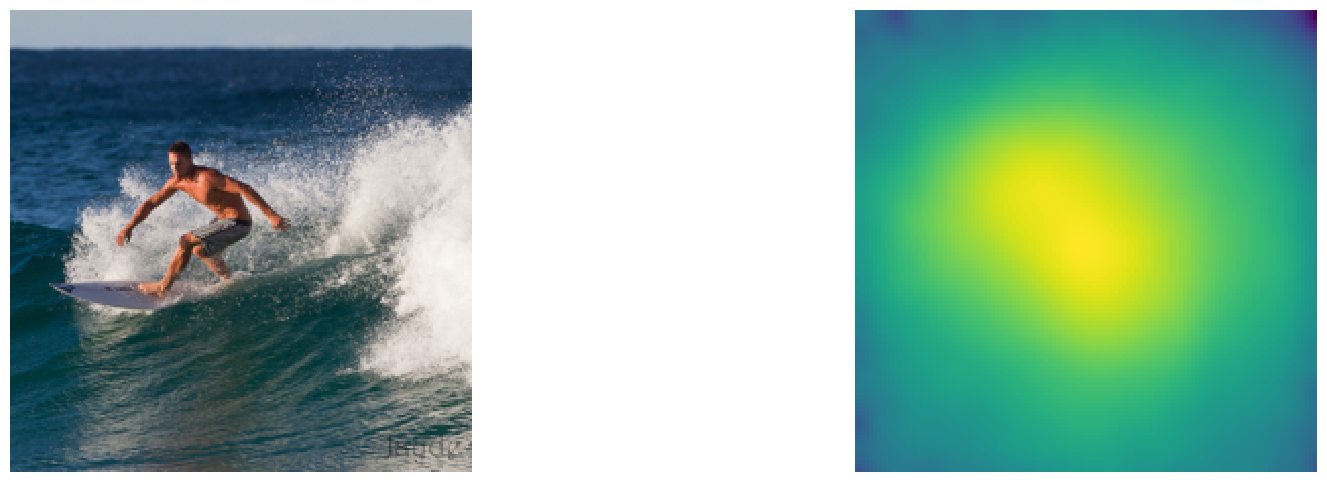

In [17]:
image = image_data[9]
print(image_data.shape)

gen_and_plot_saliency(model, image)

## Run on higher resolution images for better Saliency prediction

In [18]:
image_data_set = h5py.File(stim_file, 'r')

for key, value in image_data_set.items() :
    print(key,": \n", value,"\n")
    
image_data = np.copy(image_data_set['imgBrick'])
image_data_set.close()

imgBrick : 
 <HDF5 dataset "imgBrick": shape (73000, 425, 425, 3), type "|u1"> 



In [19]:
exp_design = loadmat(exp_design_file)
shared_idx   = exp_design['sharedix']
image_data[shared_idx[0,:]].shape

(1000, 425, 425, 3)

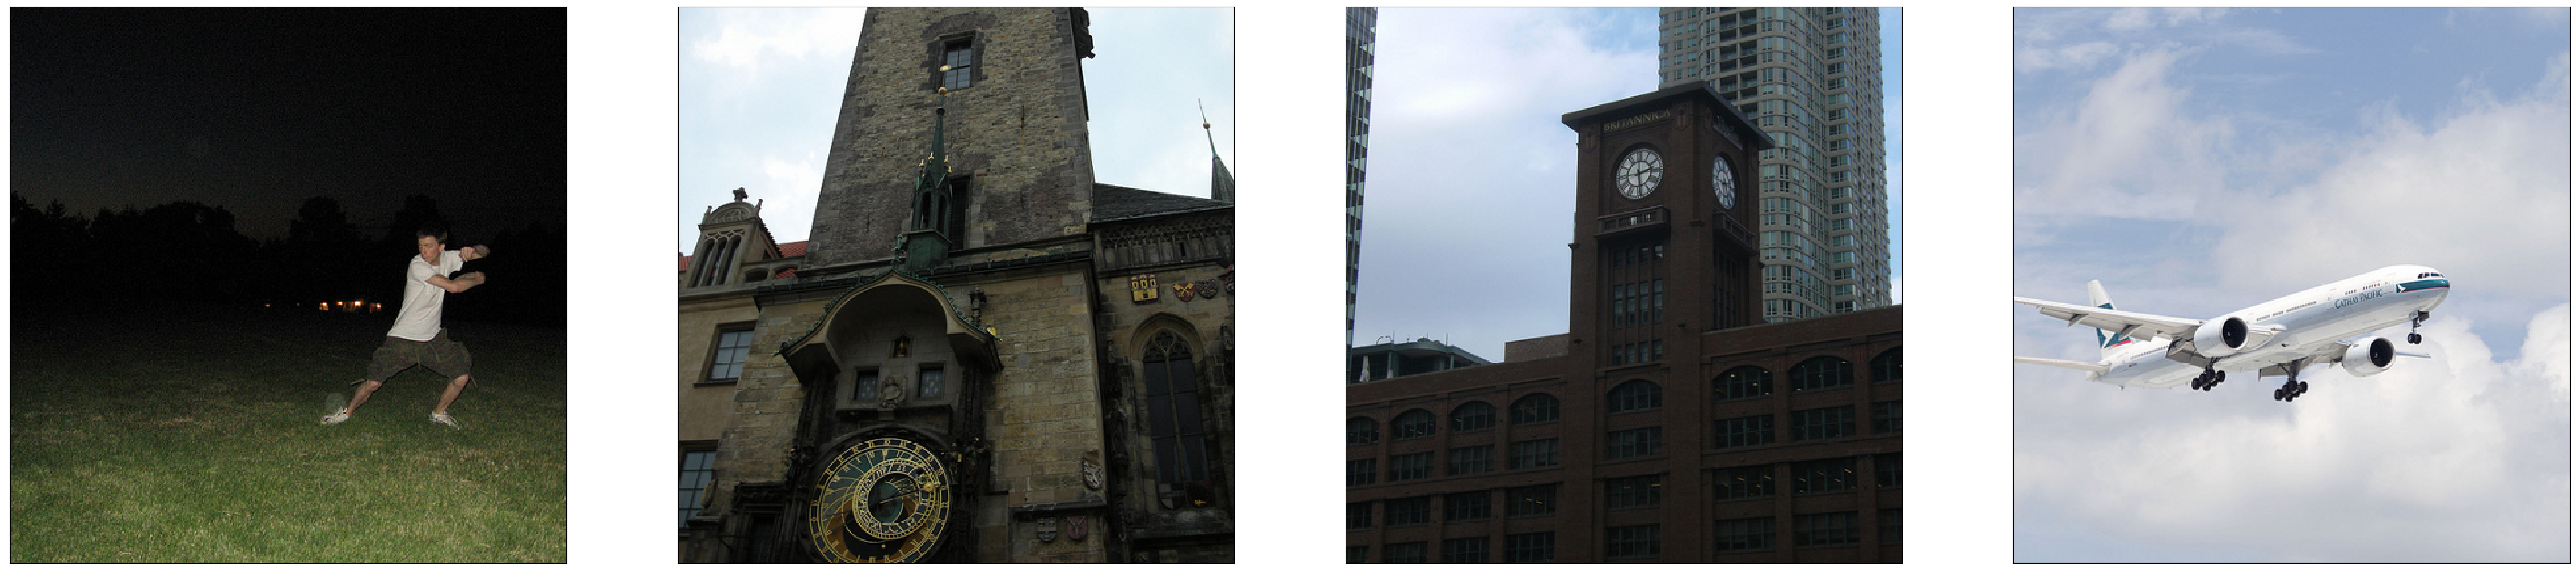

In [20]:
plt.figure(figsize=(50,20))
shared_images = image_data[shared_idx[0,:]]

for i in range(num_images):
    plt.subplot(1,num_images,i+1)
    
    plt.imshow(shared_images[5+i], cmap='gray', interpolation='None')
                        
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

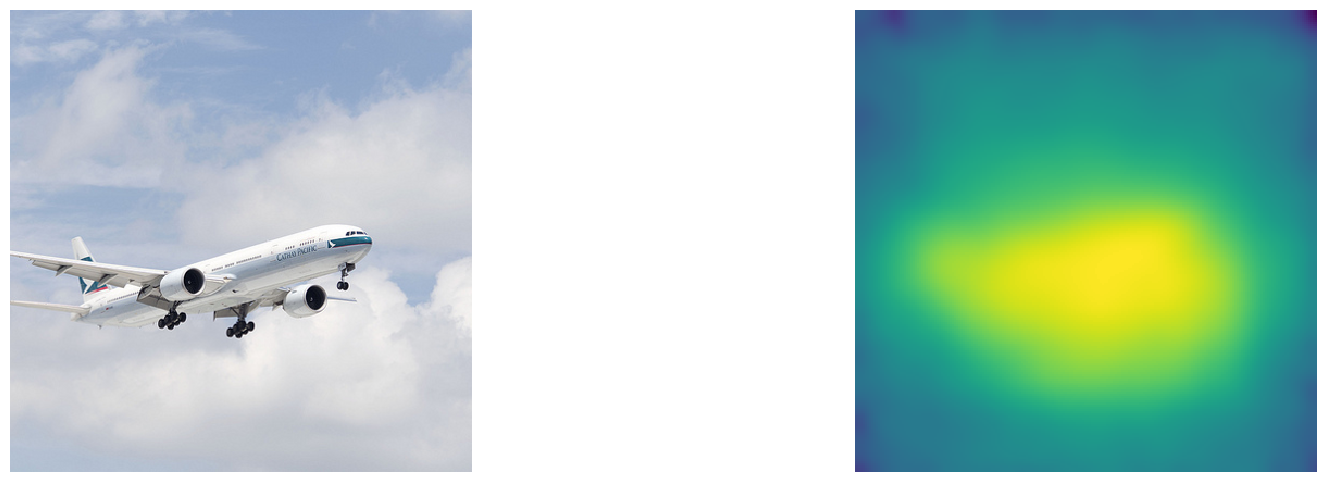

In [21]:
gen_and_plot_saliency(model, shared_images[8], channel_loc = 2 )

## Sanity check on the MIT1003 dataset

In [23]:
import glob
import cv2

In [24]:
# Images shown in the DeepGaze II paper were:

# MIT 1003 dataset: 
# Dog sign- i2254311605
# Lock in a book -i2265609722
# Graduation photo single face - i64011654
# Blurry photo of light trails - i1064999233
# 4 faces -  i114742201
# Car Dashboard - i125218174


mit1003_images_selected = []

selected_image_names = ['i2254311605.jpeg',
                        'i2265609722.jpeg',
                        'i64011654.jpeg',
                        'i1064999233.jpeg',
                        'i114742201.jpeg',
                        'i125218174.jpeg']

for file in glob.glob("/gpfs01/bartels/user/hbhatnagar/datasets/mit1003/ALLSTIMULI/*.jpeg"):
    if os.path.basename(file) in selected_image_names:
        # mit1003_images_selected.append(file)  
        # print(os.path.basename(file))
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mit1003_images_selected.append(img)
    

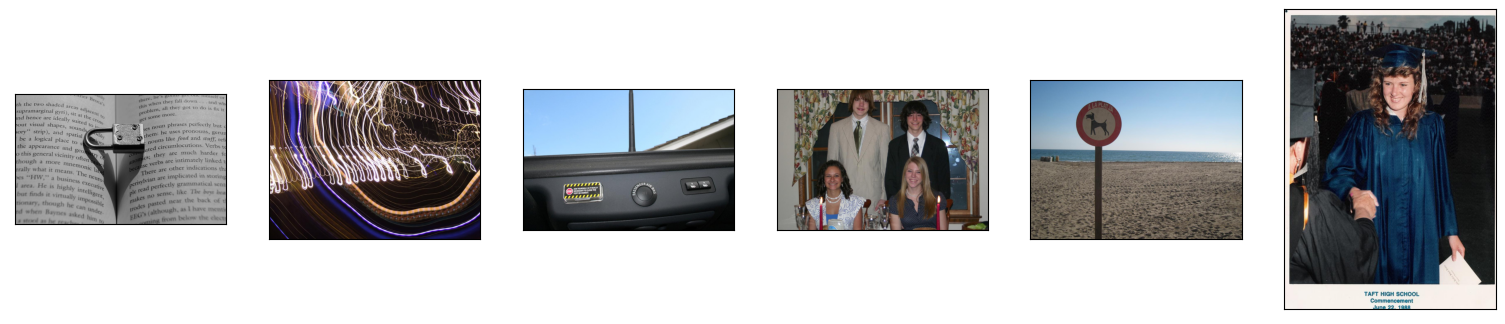

In [25]:
for i in range(0, len(mit1003_images_selected)):
    figure_size = plt.gcf().get_size_inches()
    factor = 1.2
    plt.gcf().set_size_inches(factor * figure_size) 
    plt.subplot(1,len(mit1003_images_selected),i+1)
    plt.imshow(mit1003_images_selected[i])
    
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

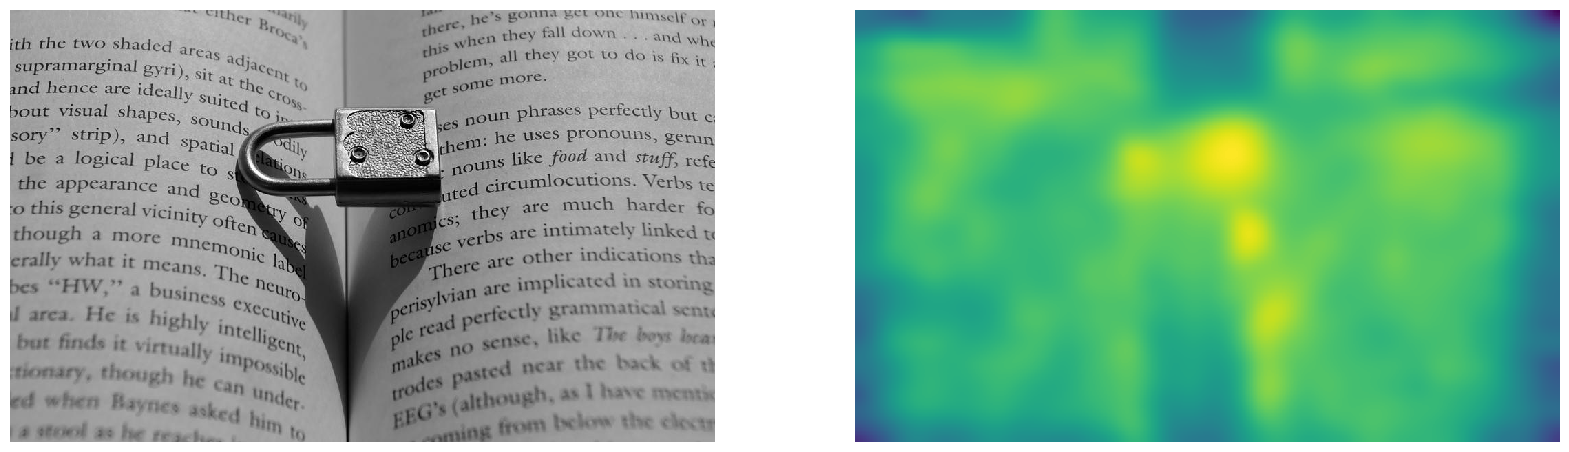

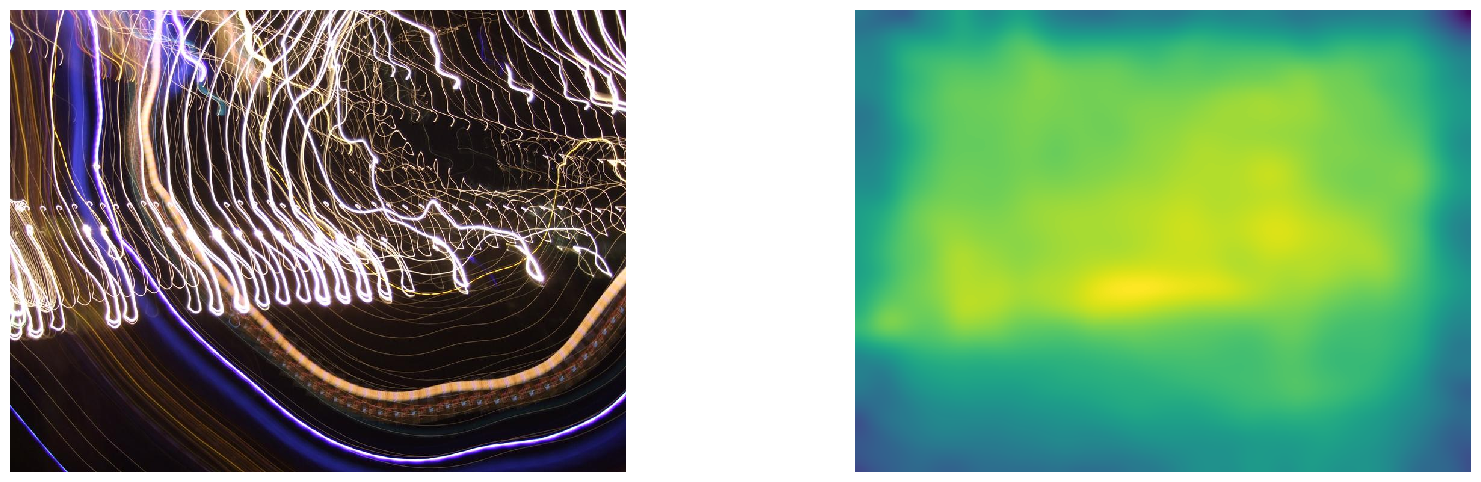

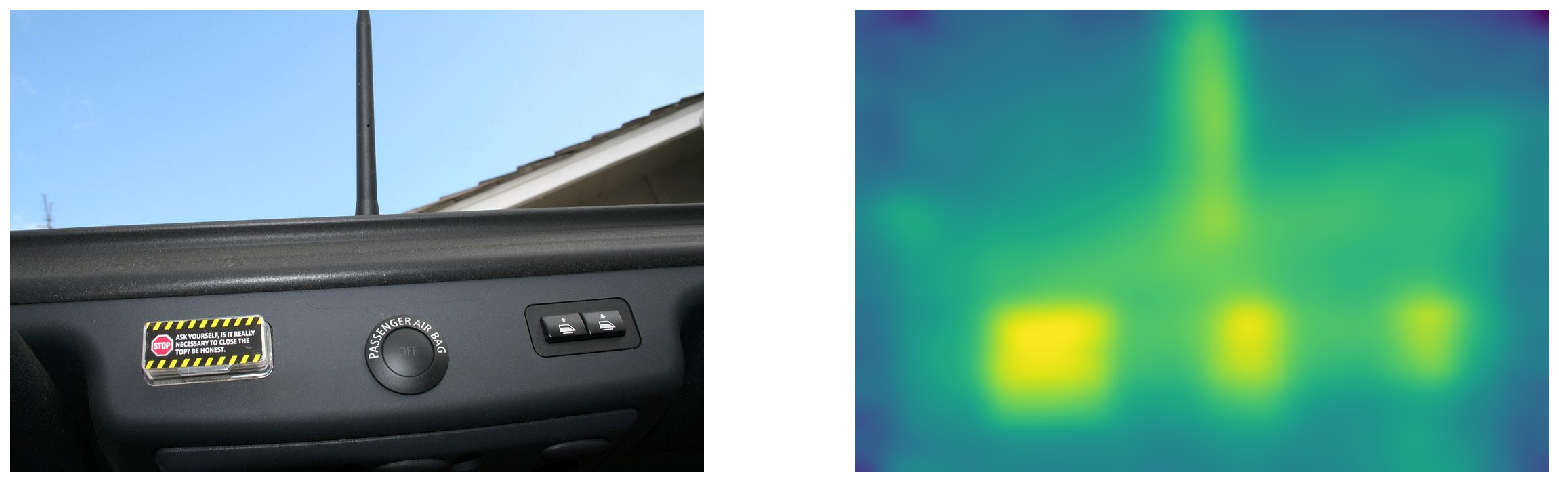

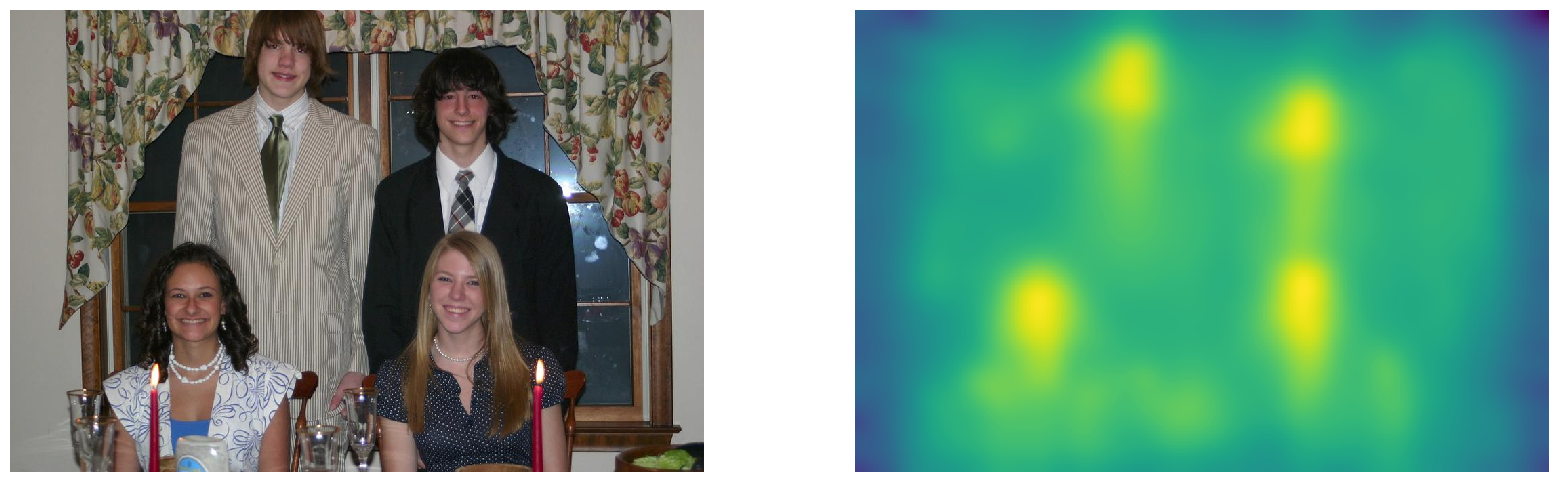

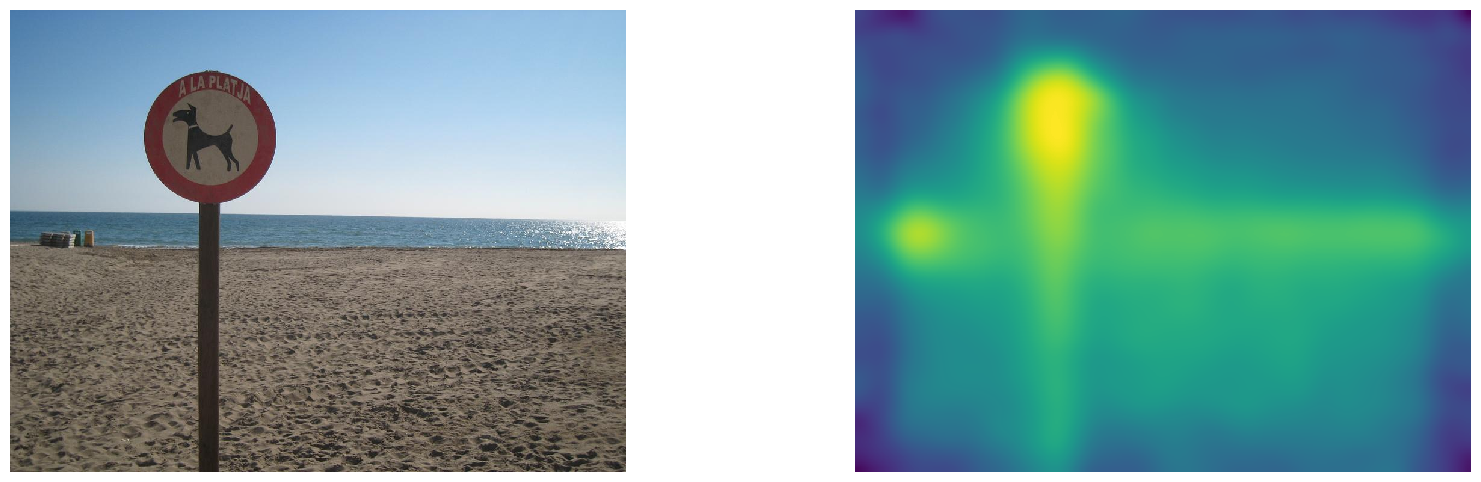

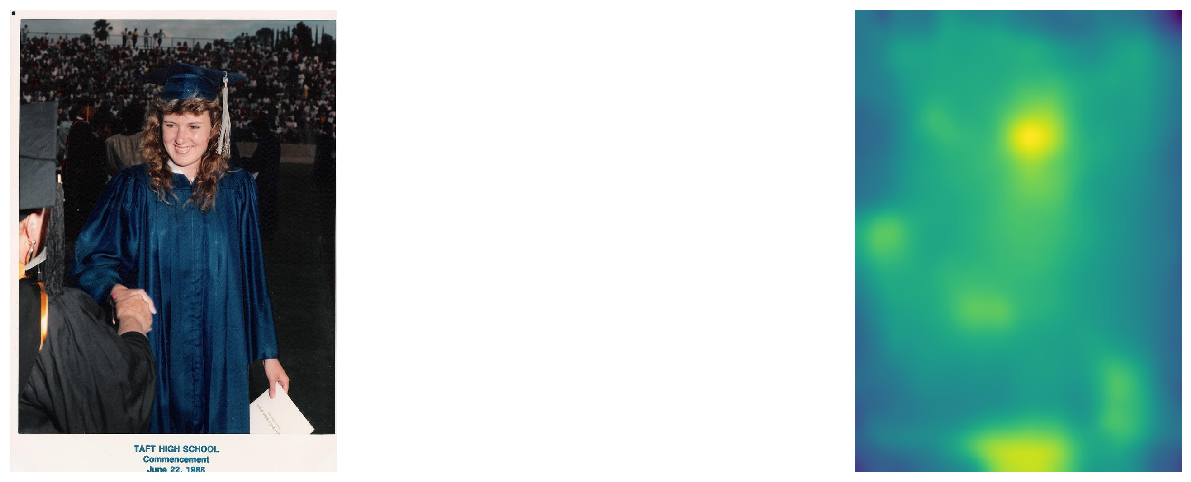

In [26]:
for i in range(0, len(mit1003_images_selected)):
    gen_and_plot_saliency(model, mit1003_images_selected[i], channel_loc = 2)

## Scale up to generate saliency map for the entire coco dataset 

In [ ]:
# function to run the saliency on the entire coco image dataset 